# Ejercicio 4
## Problema irisbin

En el archivo `irisbin.csv` se encuentran estas mediciones (en cm) junto con un código binario que indica la especie (clase) reconocida por el grupo de investigadores (`[-1 -1 1]` = **setosa**, `[-1 1 -1]` = **versicolor**, `[1 -1 -1]` = **virginica**). Para la clasificación de una gran cantidad de estas plantas se desea crear un programa que aprenda de estos 150 patrones para luego realizar la tarea de forma automática. 

Para la validación utilice los métodos *leave-k-out* y *leave-one-out* con un perceptrón multicapa como clasificador. Estime el error esperado de clasificación, su promedio y desviación estándar, según los dos métodos y compárelos.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
df = pd.read_csv('icgtp1datos/irisbin.csv', header=None)

df[7] = np.where(df[4] == 1, 'virginica', np.where(df[5] == 1, 'versicolor', 'setosa'))
df[8] = np.where(df[4] == 1, 1, np.where(df[5] == 1, 2, 3))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
 1   1       150 non-null    float64
 2   2       150 non-null    float64
 3   3       150 non-null    float64
 4   4       150 non-null    int64  
 5   5       150 non-null    int64  
 6   6       150 non-null    int64  
 7   7       150 non-null    object 
 8   8       150 non-null    int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 10.7+ KB


array([<AxesSubplot:title={'center':'0'}, xlabel='[7]'>,
       <AxesSubplot:title={'center':'1'}, xlabel='[7]'>,
       <AxesSubplot:title={'center':'2'}, xlabel='[7]'>,
       <AxesSubplot:title={'center':'3'}, xlabel='[7]'>], dtype=object)

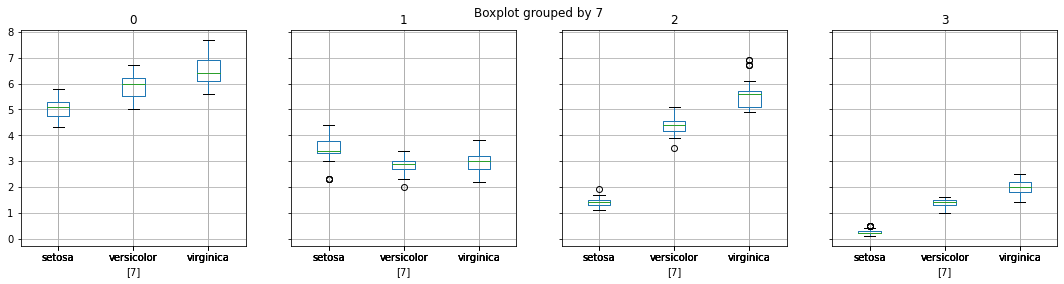

In [120]:
df[[0,1,2,3,7]].boxplot(by=7, figsize=(18,4), layout=(1,4))

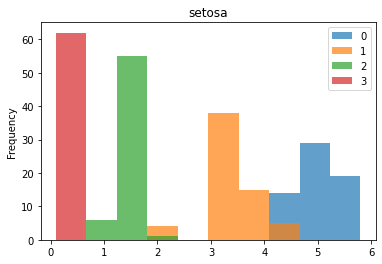

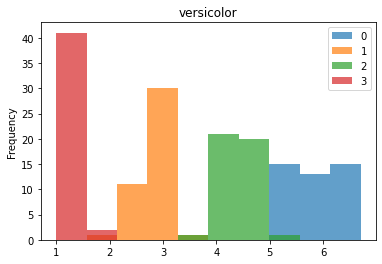

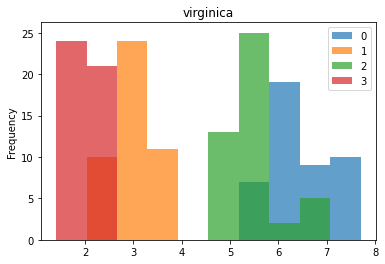

In [121]:
for title, group in df.groupby(7):
        group[[0,1,2,3]].plot.hist(title=title, alpha=0.7)

In [24]:
def leave_k_out(data_set,k):
    M_tst = []
    M_trn = []
    n_partitions=int(np.ceil(data_set.shape[0]/k))
    idx=np.random.choice(range(data_set.shape[0]),data_set.shape[0],replace = False)
    # print(idx)

    for i in range(n_partitions-1):
        tst=idx[k*i:(i+1)*k]
        trn=np.setdiff1d(idx,tst)
        M_tst.append(tst)
        M_trn.append(trn)
    
    # Para que todos las particiones queden iguales, el último
    # tiene solapamiento
    tst=idx[-k:]
    trn=np.setdiff1d(idx,tst)
    M_tst.append(tst)
    M_trn.append(trn)
        
    return (M_tst,M_trn)

def leave_one_out(data_set):
    return leave_k_out(data_set, 1)

In [20]:
rng = np.random.default_rng()

def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-1 * x))) - 1

class layer:
    def __init__(self, NNeurons, NInputs):
        # Almacenar la dimensión de entrada y cantidad de neuronas
        self.neurons_ = NNeurons
        self.inputs_ = NInputs

        # Inicializar la matriz de pesos de N x M con valores aleatorios
        # con una distribución normal centrada en 0 y norma < 0.5 aprox 
        # self.w = np.random.normal(loc = 0, scale = 0.15, size = (NNeurons, NInputs))
        self.w = rng.random((NNeurons, NInputs))
        
    def eval(self, x):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert x.shape[0] == self.inputs_, \
            f"La entrada de dimensión {x.shape[0]} no coincide con la declarada {self.inputs_}"

        # Producto interno entre la entrada y los pesos
        y = np.dot(self.w, x)
        
        # No linealidad
        z = sigmoidea(y)
        return z

class MultiLayerPerceptron:
    def __init__(self, neuronsPerLayer, NInputs):
        self.neuronsPerLayer_ = neuronsPerLayer
        self.NInputs = NInputs

        # La red estará representada como un arreglo de capas
        self.network_ = []
        
        # Auxiliar para definiar la cantidad de entradas de cada capa
        # La primera coincide con la entrada de la red
        NInputs_aux = NInputs

        # Para cada capa representada como el número de neuronas
        for layerNeurons in neuronsPerLayer:
            # Se crea una capa en base a la cantidad de salidas de la capa
            # anterior + 1 (el bias) y con el número de neuronas indicado
            self.network_.append(layer(layerNeurons, NInputs_aux + 1))
            
            # Adelantar la cantidad de entradas para la próxima capa
            NInputs_aux = layerNeurons

        # Arreglo auxiliar para almacenar los gradientes instantáneos
        self.grad_ = []
    
    def eval(self, input):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert input.shape[0] == self.NInputs, \
            f"La entrada de dimensión {input.shape[0]} no coincide con la declarada {self.NInputs}"

        # La salida de cada capa será acumulada en un arreglo
        # que es devuelto para luego utilizar en la etapa de train
        y = [input]
        
        for i in range(len(self.network_)): # Para cada capa en la red
            # Agregar el bias a la entrada de la capa i (como primer componente)
            x_ = np.hstack((-1, y[i]))

            # Calcular la salida de la capa i
            y_ = self.network_[i].eval(x_)
            
            # Agregar la salida al arreglo, que será la entrada de la siguiente
            y.append(y_)
        
        # Devolver la salida como tal, y las salidas intermedias de cada capa
        return (y[-1], y)

    def backward(self, y, yd):
        # Comprobar que la dimension de la salida calculada es igual a la de la deseada 
        assert yd.shape[0] == y[-1].shape[0], \
            f"La dimensión de la salida deseada ({yd.shape[0]}) no coincide con la calculada ({y[-1].shape[0]})"
        
        # Comprobar que la dimension de la salida deseada es igual a la cantidad de neuronas de salida 
        assert yd.shape[0] == self.neuronsPerLayer_[-1], \
            f"La dimensión de la salida deseada ({yd.shape[0]}) no coincide con la capa de salida ({self.neuronsPerLayer_[-1]})"

        # Se calcula el error entre la salida de la red (último componente de y)
        # y la salida deseada (la dimensión será la cantidad de neuronas a la salida)
        error_ = yd - y[-1]

        # Reiniciar el vector de gradientes instantaneos
        self.grad_ = []

        # Calcular el gradiente de la capa de salida y guardarlo
        self.grad_.append((np.multiply(error_, np.multiply((1 + y[-1]), (1 - y[-1])))) * 0.5)
        
        # Recorriendo las capas desde la penultima hacia la de entrada
        for i in range(len(self.network_)-1,0,-1):
            # De la capa siguiente (en el orden forward), tomar la matriz de pesos
            # sin la columna de pesos asociados al bias, y transponerla (wT_)
            wT_ = self.network_[i].w[:,1:].T

            # Calcular el gradiente local instantaneo como el producto interno entre
            # wT_ y el gradiente de error local de esa misma capa (la siguiente en orden forward)
            # en lo que se conoce como retropropagación del error
            # TODO: chequear el indexado
            d_ = np.dot(wT_, self.grad_[len(self.network_)-1-i])

            # Luego multiplicar por la derivada de la sigmoidea
            g_ = (np.multiply(d_, np.multiply((1 + y[i]), (1 - y[i])))) * 0.5
            
            # Agregar al arreglo de gradientes
            self.grad_.append(g_)

    def update(self, y, lr):
        # Actualización de pesos para cada capa
        for i in range(len(self.network_)):
            # Se calcula el producto entre el gradiente local instantáneo de la capa 
            # con la entrada de la capa (con bias), esto multiplicado por la tasa
            # de aprendizaje resulta en la matriz de actualización de pesos
            Dw_ = lr * np.outer(self.grad_[-(i+1)], np.hstack((-1, y[i])))
            
            # Los nuevos pesos se calculan como el Delta + los pesos "viejos"
            self.network_[i].w = np.add(self.network_[i].w, Dw_)

In [161]:
filename_ = 'icgtp1datos/irisbin.csv'
ds = np.genfromtxt(filename_, delimiter=',')

testPartitionsIdx, trainPartitionsIdx  =  leave_k_out(ds, 10)
# Patrones de validación
NPatternsValidation = trainPartitionsIdx[0].shape[0]

In [ ]:
# Crear un mlp y copiarlo para partir de los mismos pesos
# Configuración de red para resolver concentlite
layerStack = np.array([5, 3])

# Parámetros de entrenamiento
NEpoch = 2500               # Cantidad de épocas máximas
errorThr = 0.01             # Umbral de error para finalizar
lr = 1E-2                   # Tasa de aprendizaje

# Arreglos auxiliares para guardar el error en cada partición
epochToTrainPerPartition = []
errorRateTrainPerPartition = []
errorRateTestPerPartition = []

# Para cada partición
for i, (trainIdx, testIdx) in enumerate(zip(trainPartitionsIdx, testPartitionsIdx)):
    print(f'Partición {i+1}')
    # Generar el vector de entradas para entrenamiento y validación
    # X_val = ds[trainIdx[:NPatternsValidation], :-1]
    # X = ds[trainIdx[NPatternsValidation:], :-1]
    X = ds[trainIdx, :4]
    # Generar el vector de salida deseada para entrenamiento y validación
    # Yd_val = ds[trainIdx[:NPatternsValidation], -1]
    # Yd = ds[trainIdx[NPatternsValidation:], -1].reshape((-1,1)) 
    Yd = ds[trainIdx, -3:]

    # Crear la red en base a la dimensión de una entrada
    mlp = MultiLayerPerceptron(layerStack, X.shape[1])

    for epoch in range(NEpoch): # Para cada época
        for pattern, yd in zip(X, Yd): # Para cada patrón en la partición
            # Calcular la salida según los pesos actuales (pasada hacia adelante)
            (_, y_) = mlp.eval(pattern)
            #print(f'salida{i}={y}')

            # Realizar la propagación hacia atrás donde se calculan los gradientes
            # instantáneos (pasada hacia atrás)
            grad_ = mlp.backward(y_, yd)
            
            # Actualizar los pesos de la red
            mlp.update(y_, lr)
        
        # Para la validación se utilizarán solo algunos patrones y se calculará una
        # tasa de error, si esta es menor al umbral, se termina el proceso de entrenamiento
        # A la vez, se calculará el error cuadrático medio para tener una evolución
        # de dicha variable a lo largo de las épocas
        errorsAccum_ = 0    # Acumulador de errores
        for patron, yd in zip(X, Yd):
            # Evaluar el patron
            (z_, _) = mlp.eval(patron)
            
            # Codificación de la salida en las 3 clases
            if z_[0] == z_.max():
                y_ = [1, -1, -1]
            elif z_[1] == z_.max():
                y_ = [-1, 1, -1]
            else:
                y_ = [-1, -1, 1]
            
            # Comparación con la salida deseada y acumulación de errores
            errorsAccum_ += int(np.any(np.not_equal(y_, yd)))

        # Tasa de error: errores / patrones evaluados
        errorRate_ = (errorsAccum_/X.shape[0])

        # Si la tasa de error es menor al umbral, termina el proceso de entrenamiento
        if (errorRate_ < errorThr):
            break

        # Cada 100 épocas mostrar el error
        # if (epoch+1) % 100 == 0:
        #     print(f'Época {epoch+1}: tasa de error de {errorRatePerEpoch[-1]} | MSE promedio {MMSEPerEpoch[-1]}')
    
    # Guardar la cantidad de épocas y el error de entrenamiento
    epochToTrainPerPartition.append(epoch+1)
    errorRateTrainPerPartition.append(errorRate_)

    # Imprimir información acerca del entrenamiento
    print(f'Finalizó en la época {epoch+1} con una tasa de error de {errorRate_}')

    # Generar el vector de entradas para test
    XTest = ds[testIdx, :4]
    # Generar el vector de salida deseada para test
    YdTest = ds[testIdx, -3:]

    errorsAccum_ = 0     # Acumulador de errores
    for pattern, yd in zip(XTest, YdTest):
        # Calcular la salida
        (z_, _) = mlp.eval(pattern)
        
        # Codificación de la salida en las 3 clases
        if z_[0] == z_.max():
            y_ = [1, -1, -1]
        elif z_[1] == z_.max():
            y_ = [-1, 1, -1]
        else:
            y_ = [-1, -1, 1]
        
        # Comparación con la salida deseada y acumulación de errores
        errorsAccum_ += int(np.any(np.not_equal(y_, yd)))
    
    # Guardar el error de test
    errorRateTestPerPartition.append(errorsAccum_ / XTest.shape[0])

    print(f'Tasa de error en prueba {errorRateTestPerPartition[-1]}')

In [ ]:
print(f'Media de épocas: {np.mean(epochToTrainPerPartition):.0f}')

print(f'Media de tasa de error de entrenamiento: {np.mean(errorRateTrainPerPartition)*100.0:.3f}')
print(f'Desvío de tasa de error de entrenamiento: {np.std(errorRateTrainPerPartition)*100.0:.3f}')

print(f'Media de tasa de error de test: {np.mean(errorRateTestPerPartition)*100.0:.3f}')
print(f'Desvío de tasa de error de test: {np.std(errorRateTestPerPartition)*100.0:.3f}')

## Parámetros de entrenamiento

- Red: $[5, 3]$
- Cantidad de épocas máximas: $2500$
- Umbral de error: $1\%$
- Tasa de aprendizaje: $1 \times 10^{-2}$

## Resultados

Para `k = 1`:
- Media de épocas: $\approx 93$
- Media de tasa de error de entrenamiento: $0.667\%$
- Desvío de tasa de error de entrenamiento: $0.055\%$
- Media de tasa de error de test: $0.667\%$
- Desvío de tasa de error de test: $8.138\%$

Para `k = 10`:
- Media de épocas: $\approx 110$
- Media de tasa de error de entrenamiento: $0.667\%$
- Desvío de tasa de error de entrenamiento: $0.178\%$
- Media de tasa de error de test: $1.333\%$
- Desvío de tasa de error de test: $3.339\%$

Para `k = 15`:
- Media de épocas: $\approx 87$
- Media de tasa de error de entrenamiento: $0.667\%$
- Desvío de tasa de error de entrenamiento: $0.222\%$
- Media de tasa de error de test: $0.667\%$
- Desvío de tasa de error de test: $2.000\%$

Para `k = 30`:
- Media de épocas: $\approx 126$
- Media de tasa de error de entrenamiento: $0.833\%$
- Desvío de tasa de error de entrenamiento: $0.000\%$
- Media de tasa de error de test: $1.333\%$
- Desvío de tasa de error de test: $1.633\%$